# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [2]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import glob

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [34]:
# Add any additional import statements you need here
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
import nltk
#nltk.download('opinion_lexicon')


In [4]:
# change `data_location` to the location of the folder on your machine.
data_location = '/Users/ryan_s_dunn/opt/anaconda3/lib/python3.8/posixpath.py'

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

#lytrics filepath
cher_filepath = '/Users/ryan_s_dunn/Documents/USD MS-ADS/Applied Text Mining ADS 509/Module 2/M1 Results/lyrics/cher'
robyn_filepath = '/Users/ryan_s_dunn/Documents/USD MS-ADS/Applied Text Mining ADS 509/Module 2/M1 Results/lyrics/robyn'

#twitter desc filepath
cher_twitter_filepath = '/Users/ryan_s_dunn/Documents/USD MS-ADS/Applied Text Mining ADS 509/Module 2/M1 Results/twitter/cher/cher_followers_data.txt'
robyn_twitter_filepath = '/Users/ryan_s_dunn/Documents/USD MS-ADS/Applied Text Mining ADS 509/Module 2/M1 Results/twitter/robyn/robynkonichiwa_followers_data.txt'

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [5]:
#define function to import all txt files into a datafrmae
def import_txt_files(filepath):
    #create empty list to store dfs
    dfs = []

    #iterate over files in the directory
    for filename in os.listdir(filepath):
        if filename.endswith('.txt'):
            #read in .txt file as a df
            with open(os.path.join(filepath, filename), 'r') as f:
                song_name = f.readline().strip()
                song_lyrics = f.read().strip()
                df = pd.DataFrame({'song_name': song_name, 'song_lyrics': song_lyrics}, index=[0])
                dfs.append(df)

    # Concatenate all dataframes into one
    final_df = pd.concat(dfs, ignore_index=True)

    return final_df

#create the lyrics df's from the cher and robyn filepaths
cher_lyrics = import_txt_files(cher_filepath)
robyn_lyrics = import_txt_files(robyn_filepath)

In [6]:
# Read in the twitter data
#read in txt file as dataframe
def import_desc(filepath):
    #read in txt file as dataframe
    with open(filepath, 'r') as f:
        data = f.read().strip().split('\n')

    #create dataframe with appropriate column names
    df = pd.DataFrame([x.split('\t') for x in data], 
                      columns=['screen_name', 'name', 'id', 'location', 'followers_count', 
                               'friends_count', 'description'])

    return df

#create the twitter df's from the cher and robyn filepaths
cher_twitter = import_desc(cher_twitter_filepath)
robyn_twitter = import_desc(robyn_twitter_filepath)

In [7]:
#cher_twitter.head()

In [8]:
#robyn_twitter.head()

In [9]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

In [10]:
#read in the positive words
pos_file = '/Users/ryan_s_dunn/Documents/USD MS-ADS/Applied Text Mining ADS 509/Module 6/tm-sentiment-main/positive-words.txt'
neg_file = '/Users/ryan_s_dunn/Documents/USD MS-ADS/Applied Text Mining ADS 509/Module 6/tm-sentiment-main/negative-words.txt'
 

In [11]:
#import the positive words
def pos_words(filepath):
    # Read in the text file as a string
    with open(filepath, 'r') as f:
        text = f.read()

    # Split the text into individual words
    words = text.split()

    # Create a dataframe with the words as rows and a "rating" column with value 1
    df = pd.DataFrame(words, columns=['word'])
    df['rating'] = 1
    #citation:
    # Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." 
    # Proceedings of the ACM SIGKDD International Conference on Knowledge 
    # Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, 
    # Washington, USA, 
    return df

#create the positive df
pos_df = pos_words(pos_file)
pos_df.head(0)

,word,rating


In [12]:
#import the negative words
def neg_words(filepath):
    # Read in the text file as a string
    with open(filepath, 'r') as f:
        text = f.read()

    # Split the text into individual words
    words = text.split()

    # Create a dataframe with the words as rows and a "rating" column with value 1
    df = pd.DataFrame(words, columns=['word'])
    df['rating'] = -1
    #citation:
    # Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." 
    # Proceedings of the ACM SIGKDD International Conference on Knowledge 
    # Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, 
    # Washington, USA, 
    return df

#create the negative df
neg_df = neg_words(neg_file)
neg_df.head(0)

,word,rating


In [13]:
#import the tidytext_sentiments file
tidy_file = '/Users/ryan_s_dunn/Documents/USD MS-ADS/Applied Text Mining ADS 509/Module 6/tm-sentiment-main/tidytext_sentiments.txt'

#read in txt file as dataframe
def tidy_function(filepath):
    #read in txt file as dataframe
    with open(filepath, 'r') as f:
        data = f.read().strip().split('\n')

    #create dataframe with appropriate column names
    df = pd.DataFrame([x.split('\t') for x in data], 
                      columns=['word','sentiment','lexicon'])
    return df

#create the tidy_df dataframe
tidy_df = tidy_function(tidy_file)
tidy_df.head(2)


,word,sentiment,lexicon
0,word,sentiment,lexicon
1,abandon,negative,nrc


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [14]:
#change column names in each lyrics df
cher_lyrics.rename(columns={"song_lyrics": "text"}, inplace = True)
robyn_lyrics.rename(columns={"song_lyrics": "text"}, inplace = True)

In [15]:
#create the pos and neg scores w/ word dictionary
pos_score = 1
neg_score = -1
word_dict = {}

#positive word function
#for word in opinion_lexicon.positive(): #calls library directly
for word in pos_df['word']:
    word_dict[word] = pos_score

#negative word function
#for word in opinion_lexicon.negative(): #calls library directly
for word in neg_df['word']:
    word_dict[word] = neg_score

#calculate the sentiment function
def bing_liu_score(text):
    sentiment_score = 0 
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / len(bag_of_words)

In [16]:
#apply the function to both lyrics dataframes
cher_lyrics['Bing_Liu_Score'] = cher_lyrics['text'].apply(bing_liu_score)
robyn_lyrics['Bing_Liu_Score'] = robyn_lyrics['text'].apply(bing_liu_score)

In [17]:
cher_lyrics.head()

,song_name,text,Bing_Liu_Score
0,"""Come And Stay With Me""",I'll send away all my false pride\nAnd I'll fo...,0.017857
1,"""Pirate""",He'll sail on with the summer wind\nThat blows...,0.038710
2,"""Stars""",I was never one for saying what I really feel\...,-0.003058
3,"""These Days""",Well I've been out walking \nAnd I don't do th...,0.005682
4,"""Love So High""",Every morning I would wake up\nAnd I'd tie the...,0.051136


In [18]:
#fine the avg sentiment by lyrics by each artist
print("Cher avg sentiment is:", cher_lyrics.loc[:, 'Bing_Liu_Score'].mean())
print("Robyn avg sentiment is:", robyn_lyrics.loc[:, 'Bing_Liu_Score'].mean())

Cher avg sentiment is: 0.013219007802624888
Robyn avg sentiment is: 0.009098276416105758


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Cher has the overall more positive average sentiment by song. 

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

* Highest Positive:  "My Love", "Move Me", "Love and Understanding"
* Highest Negative:  "Cry Myself to Sleep", "Outrageous", "I Walk On Guilded Splinters"

`See the below code output for the song lyrics`

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

* Highest Positive:  "Love is Free", "Indestructable", "Indestructible (Acoustic Version)"
* Highest Negative:  "Don't Fucking Tell Me What To Do", "Criminal Intent", "Crash And Burn Girl"

`See the below code output for the song lyrics`

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

`See the below code output for the histograms`




#### Cher Top 3 Positive and Negative Song List:

In [19]:
#change the max_colwidth for the print statements
pd.set_option('max_colwidth', 1000)

#first artist (Cher) sorted values
cher_lyrics_top3 = cher_lyrics.sort_values('Bing_Liu_Score', ascending=False)
cher_lyrics_bottom3 = cher_lyrics.sort_values('Bing_Liu_Score', ascending=True)

In [20]:
##print the song name, lyrics and sentiment score of top 3 pos
cher_lyrics_top3.head(3)

,song_name,text,Bing_Liu_Score
15,"""My Love""","When I go away\nI know my heart can stay with my love\nIt's understood\nEverywhere with my love\nMy love does it good, whoa\nMy love, oh only my love\nMy love does it good\n\nAnd when the cupboard's bare\nI'll still find something there with my love\nIt's understood\nEverywhere with my love\nMy love does it so good, whoa\nMy love, oh only my love\nMy love does it good\n\nOnly my love, oh only my love\nOnly my love, hold the other things to me\nOh, only my love, oh only my love\nOnly my love does it good to me\n\nEverywhere with my love\nDon't you see my love\nIt does it so good\nOh, only my love, only my love\nMy love does it good\n\nDon't ever ask me why\nI never say ""good-bye"" to my love\nIt's understood\n'Cause everywhere with my love\nMy love does it good, whoa\nOnly my love, oh only my love\nMy love does it good\n\nOh only my love\nOnly my love does it good to me,whoa",0.221675
137,"""Move Me""","Move me\nLove the way you move me, baby\nGroove me\nLove the way you groove me\n\nMaking love with you\nLittle things that you do\nMake me feel so good inside\n\nOh oh do me\nC'mon, c'mon, do me\nBaby\nSoothe me\nLove the way you soothe me\nI love I love I love I love I love I love\nLove the way you do\n\nMove me\nLove the way you move me, baby\nGroove me\nLove the way you groove me\n\nMaking love with you\nLittle things that you do\nMake me feel so good inside\n\nI love, I love, I love the way you move me\nKeep on, keep on doin' it\nI love, I love, I love the way you move me\nKeep on, keep on doin' it\nI love, I love, I love the way you move me\nKeep on, keep on, doin' it\n[Fade out]",0.158824
146,"""Love And Understanding""","Here, here in this world\nWhere do we go? Where can we turn?\nWhen we need some love\nIt seems that love just can't be found\nWhere, where do we stand?\nWhen love's supply don't meet love's demand\n\nWe got enough stars to light the sky at night\nEnough sun to make to make the whole world bright\nWe got more than enough\nBut there's one thing there's just not enough of\n\nNot enough love and understanding\nWe could use some love to ease these troubled times\nNot enough love and understanding\nWhy, oh why?\n\nSpend all of our time\nBuilding buildings up to the sky\nReaching everywhere\nBut where we need to reach the most\nHearts never can win\nOh, in this race, this race that we're in\n\nWe've got enough cars to drive around the world\nEnough planes to take us anywhere\nWe got more than enough\nBut there's one thing there's just not enough of\n\nNot enough love and understanding\nWe could use some love to ease these troubled times\nNot enough love and understanding\nWhy, oh why?\n\n...",0.140523


In [21]:
##print the song name, lyrics and sentiment score of top 3 neg
cher_lyrics_bottom3.head(3)

,song_name,text,Bing_Liu_Score
240,"""Cry Myself To Sleep""","Every night, I lay my head\nOn my pillow on my bed\nAnd I just cry myself to sleep\n\nI know I shouldn't cry\nOver words that were all lies\nBut still, I cry myself to sleep\n\nEach night, I fight the tears\nBut still they fall\nAnd all the memories linger on\nHe's gone, he's gone\nAnd now there's nothing but to cry\nCry myself to sleep\nStill, I cry myself to sleep\n\nEach night, I fight those tears\nBut still, they fall\nAnd all the memories linger on\nHe's gone, he's gone, he's gone\nAnd now there's nothing but to cry\nAh, cry myself to sleep\nAh, cry myself to sleep\nAh, cry myself to sleep",-0.094203
158,"""Outrageous""","Outrageous, outrageous\n(They say) I'm outrageous\nIt's the rage\n\nI'm gonna wear what I will and spend some\nAnd I will be dress to kill don'tcha know\nAnd when the lights come up\nI'm ready I'm ready\nTo put on a show with class\nAnd if I clash it's cause I want to\nWhat a show and I want everyone to know\nThey're gonna fly up, get an eyeful\nEverything that's craved from me\nI'm gonna be, I'm gonna be outrageous\n\nOutrageous\n(They say) I'm outrageous\nIt's the rage it's the rage\n\nWith my long black hair hanging way down to my\nAsk me no questions and I'll tell you no lies\nDon't tell me what to do don't tell me what to be\nSee I don't trust anybody else's traits about make-up and me\n\nWell in my show I let everything go\nIs what you want is whatcha wanna see from me\nBut when the curtain comes down\nAnd you're on your way back home\nI change into my jeans that are split at the seam\nI grab my funky black jacket and make quite a racket\nYou drive like you're an outlaw\nCaus...",-0.082143
171,"""I Walk On Guilded Splinters""","Some people think they jive me, but I know they must be crazy\nThey can't see their misfortune, or else they're just too lazy\nJe suie le grand zombie\nWith my yellow chaffen of choisen\nAin't afraid of no tomcat and gonna fill my guts with poison\nI walk through the fire\nAnd I'll fly through the smoke\nI wanna see my enemies\nOn the end of my rope\nWalk on pins and needles\nAnd I see what they can do\nWalk on guilded splinters\nWith the King of the Zulu\n\nCome to me, get it, come, come\nWalk on guilded splinters\nCome to me, get it, come, come\nWalk on guilded splinters\nTill I burn up\nTill I burn up\nTill I burn up\nTill I burn up\n\nWhen I roll out in my coffin\nDrink poison in my chalice\nPride begins to fade\nAnd you all feel my malice\nI put gris-gris on your doorstep\nSo soon you be in the gutter\nI'll make your heart melt like butter\nI say I can make you stutter\n\nCome to me, get it, come, come\nWalk on guilded splinters\nCome to me, get it, come, come\nWalk on guilded...",-0.076923


#### Robyn Top 3 Positive and Negative Song List:

In [22]:
#second artist (Robyn) sorted values
robyn_lyrics_top3 = robyn_lyrics.sort_values('Bing_Liu_Score', ascending=False)
robyn_lyrics_bottom3 = robyn_lyrics.sort_values('Bing_Liu_Score', ascending=True)

In [23]:
#print the song name, lyrics and sentiment score of top 3 pos
robyn_lyrics_top3.head(3)

,song_name,text,Bing_Liu_Score
21,"""Love Is Free""","Free\nLove is free, baby\nFree\nLove is free, baby\nBoom boom boom boom boom chica boom\nLet me give it to you, baby\nChica boom chica boom chica boom\nChica boom chica boom chica boom\nFree\nLove is free, baby\nFree\nLove is free, baby\nBoom boom boom boom boom chica boom\nLet me give it to you, baby\n\nI'ma give it to you, baby\nI'ma give it when I'm ready\nSome lose, some steady\nSome light, some heavy\nIt's all over this city\nSometimes in the ugly, sometimes in the pretty\nYou never know where you get it cause you can't control it and you can't unfold it, slow down\n\nI'ma give it to you, baby\nI'ma give it when I'm ready\nSome lose, some steady\nSome light, some heavy\nIt's all over this city\nSometimes in the ugly, sometimes in the pretty\nYou never know where you get it cause you can't control it and you can't unfold it, slow down\n\nFree\nLove is free, baby\nFree\nLove is free, baby\nBoom boom boom boom boom chica boom\nLet me give it to you, baby\nYeah! Yeah! Yeah! Yeah!\...",0.178253
73,"""Indestructible""","I'm going backwards through time at the speed of light\nI'm yours, you're mine\nTwo satellites\nNot alone\nNo, we're not alone\n\nA freeze-frame of your eye in the strobe light\nSweat dripping down from your brow\nHold tight\nDon't let go\nDon't you let me go\n\nAnd I never was smart with love\nI let the bad ones in and the good ones go\n\nBut I'm gonna love you like I've never been hurt before\nI'm gonna love you like I'm indestructible\nYour love is ultramagnetic\nAnd it's taking over\nThis is hardcore\nAnd I'm indestructible\n\nHands up in the air like we don't care\nWe're shooting deep into space\nAnd the lasers split the dark\nCut right through the dark\n\nIt's just us. We ignore the crowd dancing\nFall to the floor\nBeats in my heart\nPut your hands on my heart\n\nAnd I never was smart with love\nI let the bad ones in and the good ones go\n\nBut I'm gonna love you like I've never been hurt before\nI'm gonna love you like I'm indestructible\nYour love is ultramagnetic\nAnd it'...",0.070652
23,"""Indestructible (Acoustic Version)""","I'm going backwards through time at the speed of light\nI'm yours, you're mine, two satellites\nNot alone\nNo, we're not alone\n\nA freeze-frame of your eye in the strobelight\nSweat dripping down from your brow, hold tight \nDon't let go\nDon't you let me go\n\nAnd I never was smart with love\nI let the bad ones in and the good ones go\nBut I'm gonna love you like I've never been hurt before\nI'm gonna love you like I'm indestructible\nYour love is ultra magnetic and it's taking over\nThis is hardcore\nAnd I'm indestructible\n\nHands up in the air like we don't care\nWe're shooting deep into space\nAnd the lasers split the dark\nCut right through the dark\n\nIt's just us, we ignore the crowd dancing\nFall to the floor\nBeats in my heart\nPut your hands on my heart\n\nAnd I never was smart with love\nI let the bad ones in and the good ones go\nBut I'm gonna love you like I've never been hurt before\nI'm gonna love you like I'm indestructible\nYour love is ultra magnetic and it's ta...",0.066298


In [24]:
#dont fucking tell me what to do appears twice - this function keeps the first time it appears
robyn_lyrics_bottom3 = robyn_lyrics_bottom3.drop_duplicates(keep='first')

#print the song name, lyrics and sentiment score of top 3 negative
robyn_lyrics_bottom3.head(3)

,song_name,text,Bing_Liu_Score
75,"""Don't Fucking Tell Me What To Do""","My drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\n\nMy smoking is killing me\nMy diet is killing me\nMy heels are killing me\nMy shopping's killing me\nMy ego is killing me\nCan't sleep, it's killing me\nMy label's killing me\nKickdrum\n\nMy phone is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy manager's killing me\nMy mother's killing me\nMy landlord's killing me\nMy boss is killing me\nThe TV is killing me\nYour nagging is killing me\nMy boyfriend's killing me\nMy talking's killing me\nKilling me\nKilling me\n\nCan't sleep, it's killing me\nMy dreams are killin...",-0.171946
16,"""Criminal Intent""","Somebody alert the authorities, I got criminal intent\nConspiracy to engage in lewd and indecent acts and events\nI'mma wind it, grind it, oh my, I'mma say it again\nSomebody alert the authorities, she's got criminal intent\n\nSomebody alert the authorities, I got criminal intent\nConspiracy to engage in lewd and indecent acts and events\nI'mma wind it, grind it, oh my, I'mma say it again\nSomebody alert the authorities, she's got criminal intent\n\nSomebody alert the authorities, I got criminal intent\nConspiracy to engage in lewd and indecent acts and events\nI'mma wind it, grind it, oh my, I'mma say it again\nSomebody alert the authorities, I got criminal intent\n\n- Will the defendant please rise? State your full name for the record.\n- Robyn\n- Do you wish to say anything before the sentence is imposed?\n- I do your Honor!\n\nYou know, from time to time\nI need to get down\nUnwind and just bump and grind\nGet my shot on, have some fun\nA little dirty never hurt anyone\nI admit...",-0.101961
95,"""Crash And Burn Girl""","I should write a song about you and all the shit that you do\nYou don't even know what's up\nBut soon it all comes crashing down on you\nSince we're on the subject\ntell me why your name's in the dictionary when I look up idiot\nCheck yourself, it's very necessary\n\nGet up shake your rump girl\nCause this track is for you\nAnd baby this is not a love song\n\nStop listen what's that sound\nSupersonic spinning round\nYou don't mind the fall \nuntil your face hits the ground\n\nCrash and burn girl\ngoin' down down down down down\nCrash and burn girl\nYou don't mind the fall \nuntil your face hits the ground\n\nYou should have a sticker on you saying Warning Keep Out\nYou're the kind of girl that'll mess you up for life\nthat's smashing up his car\ncrying on his doorstep\nwaiting in the rain all night\nAnd did you tell him you're the kind that\nnever show your ugly side until you sticking like glue\nShit you even go down on him\nthough he never do it for you\nTime to clear the runway ...",-0.066869


`Note:` I'd just like to say that I listed to the "Don't Fucking Tell Me What to Do" song and it's great. 

##### Plot the sentiment distributions by each artist

artist
Cher     AxesSubplot(0.125,0.125;0.775x0.755)
Robyn    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Bing_Liu_Score, dtype: object

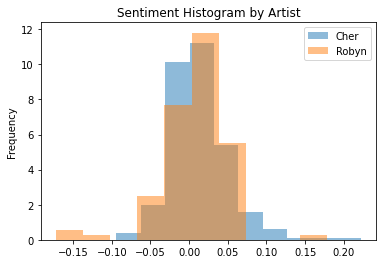

In [25]:
#create the artist column in both dataframes
cher_lyrics['artist'] = 'Cher'
robyn_lyrics['artist'] = 'Robyn'

#create object with both artists lyrics
frames = [cher_lyrics, robyn_lyrics]

#append the dataframes together
full_songs_df = pd.concat(frames)

#create the histogram of sentiment score
full_songs_df.groupby('artist')['Bing_Liu_Score'].plot(kind="hist",density=True,alpha=0.5,legend=True, 
                                                       title = "Sentiment Histogram by Artist")

The two artists have very simiar districutions, however, it appears that on the negaive end, Robyn has some very negative songs, which is likely why their mean score is lower. 

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [26]:
keep_columns = ['description']

#assign the keep columns to keep only the descriptions column
cher_desc = cher_twitter[keep_columns]
robyn_desc = robyn_twitter[keep_columns]
#cher_desc.head()

In [27]:
#positive and negative emoji lists
pos_emoji = ['😘','😍','😊','💕','🙏','💯','☺️','👌🏼','😎','❤️']
neg_emoji = ['😔','😒','😩','💔','😢','😑','😕','😤','🙁','☹️']

#create the positive/negative df's
df_pos = pd.DataFrame()
df_neg = pd.DataFrame()

#iterate through the list and add emojis to df with sentiment
for element in pos_emoji:
    data = {'element': element, 'sentiment': 1}
    df_pos = df_pos.append(data, ignore_index=True)

for element in neg_emoji:
    data = {'element': element, 'sentiment': -1}
    df_neg = df_neg.append(data, ignore_index=True)

#df_pos.head()
#df_neg.head()    

In [28]:
#calculate the sentiment score
#create the pos and neg scores w/ word dictionary
pos_score = 1
neg_score = -1
emoji_dict = {}

#positive word function
#for word in opinion_lexicon.positive(): #calls library directly
for emoji in df_pos['element']:
    emoji_dict[emoji] = pos_score

#negative word function
#for word in opinion_lexicon.negative(): #calls library directly
for emoji in df_neg['element']:
    emoji_dict[emoji] = neg_score

#create the sentiment function for emojis
def emoji_score(text):
    sentiment_score = 0 
    
    bag_of_words = word_tokenize(text.lower())  
    for word in bag_of_words:
        if type(word) == 'NoneType':
            pass
        else:
            if word in emoji_dict:
                sentiment_score += emoji_dict[word]
    return sentiment_score / len(bag_of_words) if len(bag_of_words) else 0

In [29]:
# drop the rows with blank values in the "text" column
cher_desc.dropna(subset=['description'], inplace=True)
robyn_desc.dropna(subset=['description'], inplace=True)

<ipython-input-29-e714ec28c81d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cher_desc.dropna(subset=['description'], inplace=True)
<ipython-input-29-e714ec28c81d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  robyn_desc.dropna(subset=['description'], inplace=True)


In [30]:
#apply the function to both description dataframes
cher_desc['emoji_score'] = cher_desc['description'].apply(emoji_score)
robyn_desc['emoji_score'] = robyn_desc['description'].apply(emoji_score)

<ipython-input-30-a44b6c45e3fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cher_desc['emoji_score'] = cher_desc['description'].apply(emoji_score)
<ipython-input-30-a44b6c45e3fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  robyn_desc['emoji_score'] = robyn_desc['description'].apply(emoji_score)


In [31]:
#filter the data frames to only have non-zero numbers
cher_filtered = cher_desc[cher_desc['emoji_score'] != 0.0]
robyn_filtered = robyn_desc[robyn_desc['emoji_score'] != 0.0]

In [32]:
#print the avg sentiment score of both artists
print("Cher avg emoji sentiment is:", cher_filtered.loc[:,'emoji_score'].mean())
print("Robyn avg emoji sentiment is:", robyn_filtered.loc[:,'emoji_score'].mean())

Cher avg emoji sentiment is: 0.12967758341194452
Robyn avg emoji sentiment is: 0.13974511308039955


In [64]:
#collect all emojis
cher_strings = cher_filtered.description.tolist()
robyn_string = robyn_filtered.description.tolist()

#cher lists
cher_pos_emojis = []
cher_neg_emojis = []

for element in cher_strings:
    if element in pos_emoji:
        cher_pos_emojis.append(element)
    if element in neg_emoji:
        cher_neg_emojis.append(element)

#robyn lists
robyn_pos_emojis = []
robyn_neg_emojis = []

for element in robyn_string:
    if element in pos_emoji:
        robyn_pos_emojis.append(element)
    if element in neg_emoji:
        robyn_neg_emojis.append(element)    

In [67]:
#create pos/neg lists by artist
cher_pos_count = []
cher_neg_count = []
robyn_pos_count = []
robyn_neg_count = []

#count the pos/neg emoji lists and store in the counter
cher_pos_count = Counter(cher_pos_emojis)
cher_neg_count = Counter(cher_neg_emojis)
robyn_pos_count = Counter(robyn_pos_emojis)
robyn_neg_count = Counter(robyn_neg_emojis)

#create the most commen (top 3 pos and negative emojis) by artists
top_pos_cher = cher_pos_count.most_common(3)
top_neg_cher = cher_neg_count.most_common(3)
top_pos_robyn = robyn_pos_count.most_common(3)
top_neg_robyn = robyn_neg_count.most_common(3)

#print the final output of both Cher and Robyn pos and neg
print("Cher most positive emoji:" , top_pos_cher)
print("Cher most negative emoji:" , top_neg_cher)
print("Robyn most positive emoji:" , top_pos_robyn)
print("Robyn most negative emoji:" , top_neg_robyn)

Cher most positive emoji: [('❤️', 485), ('😎', 212), ('😍', 113)]
Cher most negative emoji: [('💔', 25), ('😔', 12), ('😑', 11)]
Robyn most positive emoji: [('❤️', 46), ('😎', 16), ('☺️', 5)]
Robyn most negative emoji: [('😑', 2), ('😒', 1), ('😩', 1)]


Q: What is the average sentiment of your two artists? 

A:
* Cher = 0.1296
* Robyn = 0.1397

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: 
`See the above output for the most popular positive and negative emoji by artist`

